In [18]:
import os
import time
import json
from PIL import Image
import urllib.request
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.error import HTTPError

endpoint_url = "https://query.wikidata.org/sparql"
img_data = {}

# Requête pour récupérer les infos de l'entité donnée - Q144/Chien par défaut
def query(wd='Q144', limit=5):
    return f"""SELECT ?item ?itemLabel ?pic
                WHERE {{
                  ?item wdt:P31 wd:{wd}.
                  ?item wdt:P18 ?pic.
                  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
                }}
                LIMIT {limit}"""

def get_results(endpoint_url, query):
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    # Boucle de tentative en cas d'erreur 429 Too Many Requests
    for i in range(3):
        try:
            return sparql.query().convert()
        except HTTPError as e:
            if e.response.status_code == 429:
                retry_after = int(e.response.headers.get('Retry-After', '90'))
                print(f"Too Many Requests. Tentative dans {retry_after} secondes.")
                sleep(retry_after)
            else:
                raise e
    
    raise Exception("Nombre maximum de tentatives pour atteindre Wikidata atteint.")

# Pour créer le dossier des images s'il n'existe pas
def createFolder(name='images'):
    if name not in os.listdir():
        os.mkdir(name)
    else:
        print('Dossier '+name+' déjà existant !')

# Pour vérifier si un dossier est vide - évitons de retélécharger des images inutilement.
def isEmpty(name='images'):
    if len(os.listdir(name)) == 0:
        return True
    return False

# Pour ajouter des éléments à la bdd
def addImg(wd, limit):
    results = get_results(endpoint_url, query(wd, limit))
    for result in results['results']['bindings']:
        name_img = result['item']['value'].split("/")[-1] + "-" + wd # nom donné aux images téléchargées "numéro d'image - numéro de catégorie"        
        img_data[name_img] = {}
        downloadImage(result['pic']['value'], name_img)
        

# Ajoute les images de toutes les entités spécifiées
def addAllImg(wd, limit):
    for w in wd:
        addImg(w, limit)

# Pour télécharger l'image d'un élément de la bdd
def downloadImage(url, name_img='img0'):
    full_path = 'images/' + name_img + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    time.sleep(1)
    
# Si les images sont déjà téléchargées on initialise le tableau
def initAlreadyDownload(namefolder='images'):
    for image in os.listdir(namefolder):
        img_data[image.split(".")[0]] = {}

# Pour télécharger toutes les images - limit par query
def downloadAllImages(wd=['Q144'], limit=5):
    createFolder()
    if not isEmpty():
        print('Images déjà téléchargées !')
        initAlreadyDownload()
        return False
    addAllImg(wd, limit)
    return True 



bdd = ['Q144','Q14660','Q23442','Q28803','Q3305213'] #Chien, drapeau, ile, sandwich, peinture,
downloadAllImages(wd=bdd,limit=30)
print(img_data)


Dossier images déjà existant !
Images déjà téléchargées !
{'Q1060353-Q144': {}, 'Q109353074-Q28803': {}, 'Q111589124-Q28803': {}, 'Q113945861-Q28803': {}, 'Q1171851-Q144': {}, 'Q12065066-Q144': {}, 'Q124351850-Q28803': {}, 'Q1320354-Q144': {}, 'Q1360835-Q144': {}, 'Q13647435-Q144': {}, 'Q1393864-Q144': {}, 'Q1408045-Q28803': {}, 'Q1502051-Q144': {}, 'Q1554131-Q144': {}, 'Q155695-Q144': {}, 'Q16069677-Q144': {}, 'Q16846342-Q144': {}, 'Q16938954-Q144': {}, 'Q1760470-Q28803': {}, 'Q18392844-Q144': {}, 'Q18408091-Q144': {}, 'Q186486-Q144': {}, 'Q192540-Q23442': {}, 'Q192767-Q23442': {}, 'Q193089-Q23442': {}, 'Q193253-Q23442': {}, 'Q193264-Q23442': {}, 'Q193331-Q23442': {}, 'Q19362107-Q144': {}, 'Q19362108-Q144': {}, 'Q193896-Q23442': {}, 'Q193962-Q23442': {}, 'Q194215-Q23442': {}, 'Q194364-Q23442': {}, 'Q194446-Q23442': {}, 'Q194451-Q23442': {}, 'Q194522-Q23442': {}, 'Q195674-Q23442': {}, 'Q195675-Q23442': {}, 'Q195792-Q23442': {}, 'Q196042-Q23442': {}, 'Q200223-Q23442': {}, 'Q200226-Q2344

In [2]:
import os
import json
from PIL import Image
import urllib.request
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.error import HTTPError
import time
import shutil
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import webcolors

#Supprimer une image du dossier 
def removeImage(name):
    image_path = "images/" + name
    if os.path.isfile(image_path):
        os.remove(image_path)
        print(f"L'image {name} a été supprimée.")
    else:
        print(f"Impossible de trouver le fichier {image_path}")

#Obtenir les metas d'une image
def getMetaImg(name, imgfile):
    #clés Exif
    DATE_KEY = 36867
    MODEL_KEY = 272
    
    img_data[name].update({
        #'size': [getSizeImg(imgfile.size), imgfile.size],
        'size': getSizeImg(imgfile.size),
        'orientation': getOrientationImg(imgfile.size),
        'format': imgfile.format,
    })
    
    getColorsImg(name, imgfile)
    
    exif_data = imgfile._getexif()
    if exif_data is not None:
        if DATE_KEY in exif_data:
            img_data[name]['date'] = exif_data[DATE_KEY]
        if MODEL_KEY in exif_data:
            img_data[name]['model'] = exif_data[MODEL_KEY]

def getOrientationImg(size): #(largeur,hauteur)
    width,height = size
    return "landscape" if width > height else "portrait" if height > width else "squared"
    
def getSizeImg(size): #(largeur,hauteur)
    width,height = size
    return "large" if width*height>1920*1080 else "small" if width*height<640*480 else "medium"
    
def getColorsImg(name, imgfile, cluster_nbr=2, n_init=1):
    img_data[name]['colors'] = []
    
    # Redimensionner l'image pour accélérer le traitement
    imgfile = imgfile.resize((int(imgfile.size[0]/2), int(imgfile.size[1]/2)))

    # Convertir l'image en un tableau numpy
    img_array = np.array(imgfile)
    try:
        img_vector = img_array.reshape(-1, 3)
        clusters = MiniBatchKMeans(n_clusters=cluster_nbr, n_init=n_init, random_state=69).fit(img_vector) #Random state pour garder la meme seed ppour toutes les images

        for i, center in enumerate(clusters.cluster_centers_):
            rgb = tuple(map(int, center))
            img_data[name]['colors'].append(rgb)
            
    except Exception as e:
        print(f'Pas de couleur : {e}')
        

def RGBtoName(rgb):
    try:
        # Attempt to find the exact color name
        color_name = webcolors.rgb_to_name(rgb)
    except ValueError:
        # If exact name not found, find the closest color name
        min_difference = None
        closest_color = None
        for name, hex_value in webcolors.CSS3_NAMES_TO_HEX.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(hex_value)
            difference = sum([(r_c - rgb[0]) ** 2, (g_c - rgb[1]) ** 2, (b_c - rgb[2]) ** 2])
            if min_difference is None or difference < min_difference:
                min_difference = difference
                closest_color = name
        color_name = closest_color
    return color_name

def openImgGetMeta(name): #name = 'img.jpg'
    try:
        with Image.open("images/"+name) as imgfile:
            #print(imgfile.size, imgfile.format)
            name = name.split(".")[0]
            getMetaImg(name, imgfile)

        imgfile.close()
        return True
    except FileNotFoundError as e:
        print('Impossible de trouver le fichier {}: {}'.format("images/"+name, e))
        return False
    except Exception as e:
        print('Erreur lors de l\'ouverture de l\'image {}: {}'.format("images/"+name, e))
        removeImage(name)
        return False
import os
import json



#Obtenir les metas de toutes nos images    
def openGetMetaAllImg(namefolder='images'):
    for image in os.listdir(namefolder):
        # Ignore .ipynb_checkpoints and non-image files
        if image.endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
            openImgGetMeta(image)


openGetMetaAllImg()


Erreur lors de l'ouverture de l'image images/Q111589124-Q28803: _getexif
Impossible de trouver le fichier images/Q111589124-Q28803
Pas de couleur : cannot reshape array of size 95914 into shape (3)
Pas de couleur : cannot reshape array of size 67760 into shape (3)


In [92]:
import requests
from random import randint, choice
import json

#Enregistre les metadonnées des images dans un JSON
def exportToJSON(data,name='img_data.json'):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print("done")

def openJSON(file="img_data.json"):
    if not os.path.exists(file):
        with open(file, 'w') as f:
            json.dump({}, f)
        with open(file, 'r') as f:
            data = json.load(f)
        return data
    
# Requête API à Wikidata pour récupérer les catégories de l'image
def wikidataAPI(_id,lang):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=labels|claims&languages={lang}&format=json"
    response = requests.get(url)
    return json.loads(response.text)

def findTagsImg(_id, lang='en'): #"Q7704028-Q144"
    image_id, cat_id = _id.split("-")
    # Requête API à Wikidata pour récupérer les catégories de l'image
    img_data = wikidataAPI(image_id,lang)
    cat_data = wikidataAPI(cat_id,lang)
    # Extraire le libellé de la catégorie dans la langue souhaitée
    main_tag = cat_data.get('entities', {}).get(cat_id, {}).get('labels', {}).get(lang, {}).get('value', '')
    # Trouver les catégories dans la réponse de la requête API sur l'image
    claims = img_data.get("entities", {}).get(image_id, {}).get("claims", {})
    categories = formatCategory([x['mainsnak']['datavalue']['value'] for prop in ["P910", "P373"] for x in claims.get(prop, [])])
    if main_tag not in categories:
        categories.append(main_tag)
    categories = [main_tag]    
    return categories

def formatCategory(categories):
    categories_ = []
    removeCar = ['(', ')']
    splitCar = [',', ' ']
    for category in categories:
        if isinstance(category, str):
            for car in removeCar:
                category = category.replace(car, '')
            for car in splitCar:
                parts = category.split(car)
                if len(parts) > 1:
                    categories_.extend(parts[1:])
                    category = parts[0]
            categories_.append(category.lower())
    return categories_

def addTagsJSON(image_id = "Q7704028", categories=[]):
    data = openJSON(file="img_data.json")
    data[image_id]['tags'] = categories
    
def delete_image_without_color_metadata(json_file='img_data.json', image_folder='images'):
    with open(json_file, 'r') as f:
        json_data = json.load(f)

    images_to_delete = []

    for image in json_data:
        if not 'colors' in json_data[image] or not json_data[image].get("colors",False):
            images_to_delete.append(image)

    for image in images_to_delete:
        if os.path.isfile(os.path.join(image_folder, image)):
            os.remove(os.path.join(image_folder, image))
        del json_data[image]
    print(f"{len(images_to_delete)} images ont été supprimées")

    with open(json_file, 'w') as f:
        json.dump(json_data, f)
    return json_data

def data_formatage(data):
    for image in data:
        if not data[image].get("size",False):
            data[image]["size"] = ""
        if not data[image].get("orientation",False):
            data[image]["orientation"] = ""
        if not data[image].get("format",False):
            data[image]["format"] = choice(["JPEG","PNG","JPG"])
        if not data[image].get("tags",False):
            data[image]["tags"] = ""
        data[image]["date"]=randint(1999,2024)
        if not data[image].get("model", False):
            data[image]["model"]=choice(["Canon","Nikon", "Sony","Fujifilm","Olympus","Panasonic","Pentax","iphone","samsung","lenovo"])         
    return data

def addAllTagsJSON():
    for _id in data:
        data[_id]['tags'] = findTagsImg(_id)
    return data


data = img_data
data = addAllTagsJSON()
data = data_formatage(data)
exportToJSON(data)

img_data = delete_image_without_color_metadata()

done
32 images ont été supprimées


In [3]:
class User:
    def __init__(self, favorite_pictures=None):
        self._favorite_colors = []
        self._favorite_orientations = []
        self._favorite_sizes = []
        self._favorite_tags = []
        self._favorite_pictures = [] if favorite_pictures is None else favorite_pictures

    def __str__(self):
        return f"User with favorite color {self._favorite_colors}, orientation {self._favorite_orientations}, size {self._favorite_sizes}, tags {self._favorite_tags} and favorite pictures {self._favorite_pictures}"

    def add_favorite_picture(self, picture):
        self._favorite_pictures.append(picture)
        img_data = data[picture.split(".")[0]]
        self._favorite_colors.append(img_data["colors"])
        self._favorite_orientations.append(img_data["orientation"])
        self._favorite_tags.append(img_data["tags"])
        self._favorite_sizes.append(img_data["size"])

    def remove_favorite_picture(self, picture):
        picture_index = self._favorite_pictures.index(picture)
        self._favorite_pictures.pop(picture_index)
        self._favorite_colors.pop(picture_index)
        self._favorite_orientations.pop(picture_index)
        self._favorite_tags.pop(picture_index)
        self._favorite_sizes.pop(picture_index)

    def get_favorite_pictures(self):
        return self._favorite_pictures

    def get_favorite_tags(self):
        return self._favorite_tags

    def get_favorite_orientations(self):
        return self._favorite_orientations

    def get_favorite_colors(self):
        return self._favorite_colors

    def get_favorite_sizes(self):
        return self._favorite_sizes


In [4]:
import pandas as pd 
dataFrame = pd.read_json('img_data.json').T
dataFrame

C:\Users\chaha\AppData\Local\Temp\ipykernel_11552\2483933940.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,size,orientation,format,colors,date,model,tags
Q7660509-Q144,large,landscape,JPEG,"[[121, 168, 111], [27, 47, 28]]",2010,DSC-H50,[dog]
Q7704028-Q144,medium,landscape,JPEG,"[[173, 173, 172], [36, 36, 35]]",1999,Panasonic,[dog]
Q7802871-Q144,large,portrait,JPEG,"[[166, 146, 135], [102, 59, 50]]",2005,Fujifilm,[dog]
Q7809730-Q144,small,landscape,JPEG,"[[163, 163, 163], [119, 109, 102]]",2008,Panasonic,[dog]
Q9049682-Q144,medium,portrait,JPEG,"[[106, 97, 86], [245, 242, 238]]",2021,DSC-P150,[dog]
...,...,...,...,...,...,...,...
Q282277-Q3305213,large,portrait,JPEG,"[[59, 49, 37], [167, 150, 121]]",2006,Fujifilm,[painting]
Q283665-Q3305213,medium,landscape,JPEG,"[[40, 33, 29], [179, 153, 120]]",2013,Panasonic,[painting]
Q285392-Q3305213,large,landscape,JPEG,"[[78, 52, 26], [180, 149, 108]]",2024,Sony,[painting]
Q286096-Q3305213,large,portrait,JPEG,"[[170, 146, 114], [60, 32, 27]]",2022,HP Scanjet G3010,[painting]


In [5]:
import random
# Créer une liste d'utilisateurs vides
number_users = 15
users = [None] * number_users

# Créer un utilisateur avec une liste aléatoire de photos préférées
for i in range(number_users):

    number_pictures_liked = random.randint(10, 30)

    max_pictures_liked = min(len(dataFrame), 30)
    if max_pictures_liked == 0:
        print("Il n'y a pas d'images dans le répertoire.")
    else:
        number_pictures_liked = random.randint(1, max_pictures_liked)

    user = User(favorite_pictures=random.sample(list(dataFrame.index), k=number_pictures_liked))
    users[i] = user
    print(user.get_favorite_pictures())


['Q53844640-Q28803', 'Q194522-Q23442', 'Q13647435-Q144', 'Q16938954-Q144', 'Q259012-Q3305213', 'Q1408045-Q28803', 'Q18408091-Q144', 'Q200223-Q23442', 'Q194451-Q23442', 'Q186486-Q144']
['Q247282-Q3305213', 'Q7802871-Q144', 'Q16938954-Q144', 'Q265201-Q3305213', 'Q259012-Q3305213', 'Q195674-Q23442', 'Q85774221-Q28803', 'Q641561-Q144', 'Q282277-Q3305213', 'Q5056486-Q28803', 'Q232087-Q3305213', 'Q7660509-Q144', 'Q257580-Q3305213', 'Q241455-Q3305213', 'Q5613356-Q28803', 'Q202422-Q23442', 'Q193253-Q23442', 'Q687727-Q144', 'Q194364-Q23442', 'Q7809730-Q144']
['Q202170-Q23442', 'Q1171851-Q144', 'Q193089-Q23442', 'Q2919135-Q28803', 'Q111589124-Q28803', 'Q18392844-Q144', 'Q9049682-Q144', 'Q94719064-Q28803', 'Q220859-Q3305213', 'Q16846342-Q144', 'Q210277-Q3305213', 'Q76846839-Q28803', 'Q193331-Q23442', 'Q201026-Q23442', 'Q1360835-Q144', 'Q1502051-Q144', 'Q155695-Q144', 'Q5736147-Q28803', 'Q1408045-Q28803', 'Q18408091-Q144', 'Q202023-Q23442', 'Q384348-Q144', 'Q94208532-Q28803', 'Q254923-Q3305213', '

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Charger les données à partir du fichier JSON
dataFrame = pd.read_json('img_data.json').T

# Convertir la taille en une valeur numérique
dataFrame['size'] = dataFrame['size'].map({'small': 0, 'medium': 0.5, 'large':1})

# Convertir l'orientation en une valeur numérique
dataFrame['orientation'] = dataFrame['orientation'].map({'landscape': 0, 'portrait': 1, 'squared':0.5})

# Convertir l'orientation en une valeur numérique
dataFrame['format'] = dataFrame['format'].map({'JPEG': 0, 'MPO': 0.5, 'PNG':1})

# Vérifier si la valeur de la colonne 'colors' est une liste
dataFrame['colors'] = dataFrame['colors'].apply(lambda x: [[0,0,0], [0,0,0]] if isinstance(x, float) else x)

# Ajouter les 6 colonnes de couleurs séparées
dataFrame["r1"] = [couleur[0][0]/255 if len(couleur) > 0 and len(couleur[0]) > 0 else 0 for couleur in dataFrame["colors"]]
dataFrame["g1"] = [couleur[0][1]/255 if len(couleur) > 0 and len(couleur[0]) > 1 else 0 for couleur in dataFrame["colors"]]
dataFrame["b1"] = [couleur[0][2]/255 if len(couleur) > 0 and len(couleur[0]) > 2 else 0 for couleur in dataFrame["colors"]]
dataFrame["r2"] = [couleur[1][0]/255 if len(couleur) > 1 and len(couleur[1]) > 0 else 0 for couleur in dataFrame["colors"]]
dataFrame["g2"] = [couleur[1][1]/255 if len(couleur) > 1 and len(couleur[1]) > 1 else 0 for couleur in dataFrame["colors"]]
dataFrame["b2"] = [couleur[1][2]/255 if len(couleur) > 1 and len(couleur[1]) > 2 else 0 for couleur in dataFrame["colors"]]

# Convertir les valeurs RGB en hexadécimal
dataFrame["hex1"] = dataFrame.apply(lambda row: '#{:02x}{:02x}{:02x}'.format(int(row["r1"]*255), int(row["g1"]*255), int(row["b1"]*255)), axis=1)
dataFrame["hex2"] = dataFrame.apply(lambda row: '#{:02x}{:02x}{:02x}'.format(int(row["r2"]*255), int(row["g2"]*255), int(row["b2"]*255)), axis=1)

# Supprimer les colonnes inutiles
dataFrame = dataFrame.drop(columns=['colors'])
dataFrame = dataFrame.drop(columns=['date','model'])

# Binariser les tags
mlb = MultiLabelBinarizer()
tags_binarized = mlb.fit_transform(dataFrame['tags'])
tags_df = pd.DataFrame(tags_binarized, columns=mlb.classes_, index=dataFrame.index)
dataFrame = pd.concat([dataFrame, tags_df], axis=1)
dataFrame.drop('tags', axis=1, inplace=True)

# Ajouter la colonne "liked"
dataFrame['liked'] = np.zeros(len(dataFrame['r1'].index))
for img in user._favorite_pictures:
    dataFrame.at[img.split('.')[0], 'liked'] = 1
dataFrame

,size,orientation,format,r1,g1,b1,r2,g2,b2,hex1,hex2,dog,flag,island,painting,sandwich,liked
Q7660509-Q144,1.0,0.0,0.0,0.474510,0.658824,0.435294,0.105882,0.184314,0.109804,#79a86f,#1b2f1c,1,0,0,0,0,0.0
Q7704028-Q144,0.5,0.0,0.0,0.678431,0.678431,0.674510,0.141176,0.141176,0.137255,#adadac,#242423,1,0,0,0,0,1.0
Q7802871-Q144,1.0,1.0,0.0,0.650980,0.572549,0.529412,0.400000,0.231373,0.196078,#a69287,#663b32,1,0,0,0,0,0.0
Q7809730-Q144,0.0,0.0,0.0,0.639216,0.639216,0.639216,0.466667,0.427451,0.400000,#a3a3a3,#776d66,1,0,0,0,0,1.0
Q9049682-Q144,0.5,1.0,0.0,0.415686,0.380392,0.337255,0.960784,0.949020,0.933333,#6a6156,#f5f2ee,1,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q282277-Q3305213,1.0,1.0,0.0,0.231373,0.192157,0.145098,0.654902,0.588235,0.474510,#3b3125,#a79679,0,0,0,1,0,0.0
Q283665-Q3305213,0.5,0.0,0.0,0.156863,0.129412,0.113725,0.701961,0.600000,0.470588,#28211d,#b39978,0,0,0,1,0,0.0
Q285392-Q3305213,1.0,0.0,0.0,0.305882,0.203922,0.101961,0.705882,0.584314,0.423529,#4e341a,#b4956c,0,0,0,1,0,0.0
Q286096-Q3305213,1.0,1.0,0.0,0.666667,0.572549,0.447059,0.235294,0.125490,0.105882,#aa9272,#3c201b,0,0,0,1,0,0.0


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random

# Assuming dataFrame is defined and contains your image data
total_images = len(dataFrame)
min_likes = int(0.05 * total_images)  # 5% of total
max_likes = int(0.20 * total_images)  # 20% of total
number_of_likes = random.randint(min_likes, max_likes)  # Random number between 5% and 20%

# Initialize resultframe with all images as 'not liked'
resultframe = pd.DataFrame(np.full(total_images, "not liked"), columns=['liked'], index=dataFrame.index)

# Randomly select images to like
liked_indices = random.sample(list(dataFrame.index), number_of_likes)
for index in liked_indices:
    resultframe.at[index, 'liked'] = 'liked'

# Encode the 'liked' labels
le7 = LabelEncoder()
resultframe['liked'] = le7.fit_transform(resultframe['liked'])

print(f"Number of images liked: {number_of_likes}")
print(resultframe)


Number of images liked: 15
                  liked
Q7660509-Q144         1
Q7704028-Q144         1
Q7802871-Q144         1
Q7809730-Q144         1
Q9049682-Q144         1
...                 ...
Q282277-Q3305213      1
Q283665-Q3305213      1
Q285392-Q3305213      0
Q286096-Q3305213      0
Q287169-Q3305213      1

[104 rows x 1 columns]


(104, 17)
(104, 1)
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.76      0.86        21

    accuracy                           0.76        21
   macro avg       0.50      0.88      0.43        21
weighted avg       1.00      0.76      0.86        21



C:\Users\chaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\extmath.py:1108: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\chaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\extmath.py:1113: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\chaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\extmath.py:1133: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


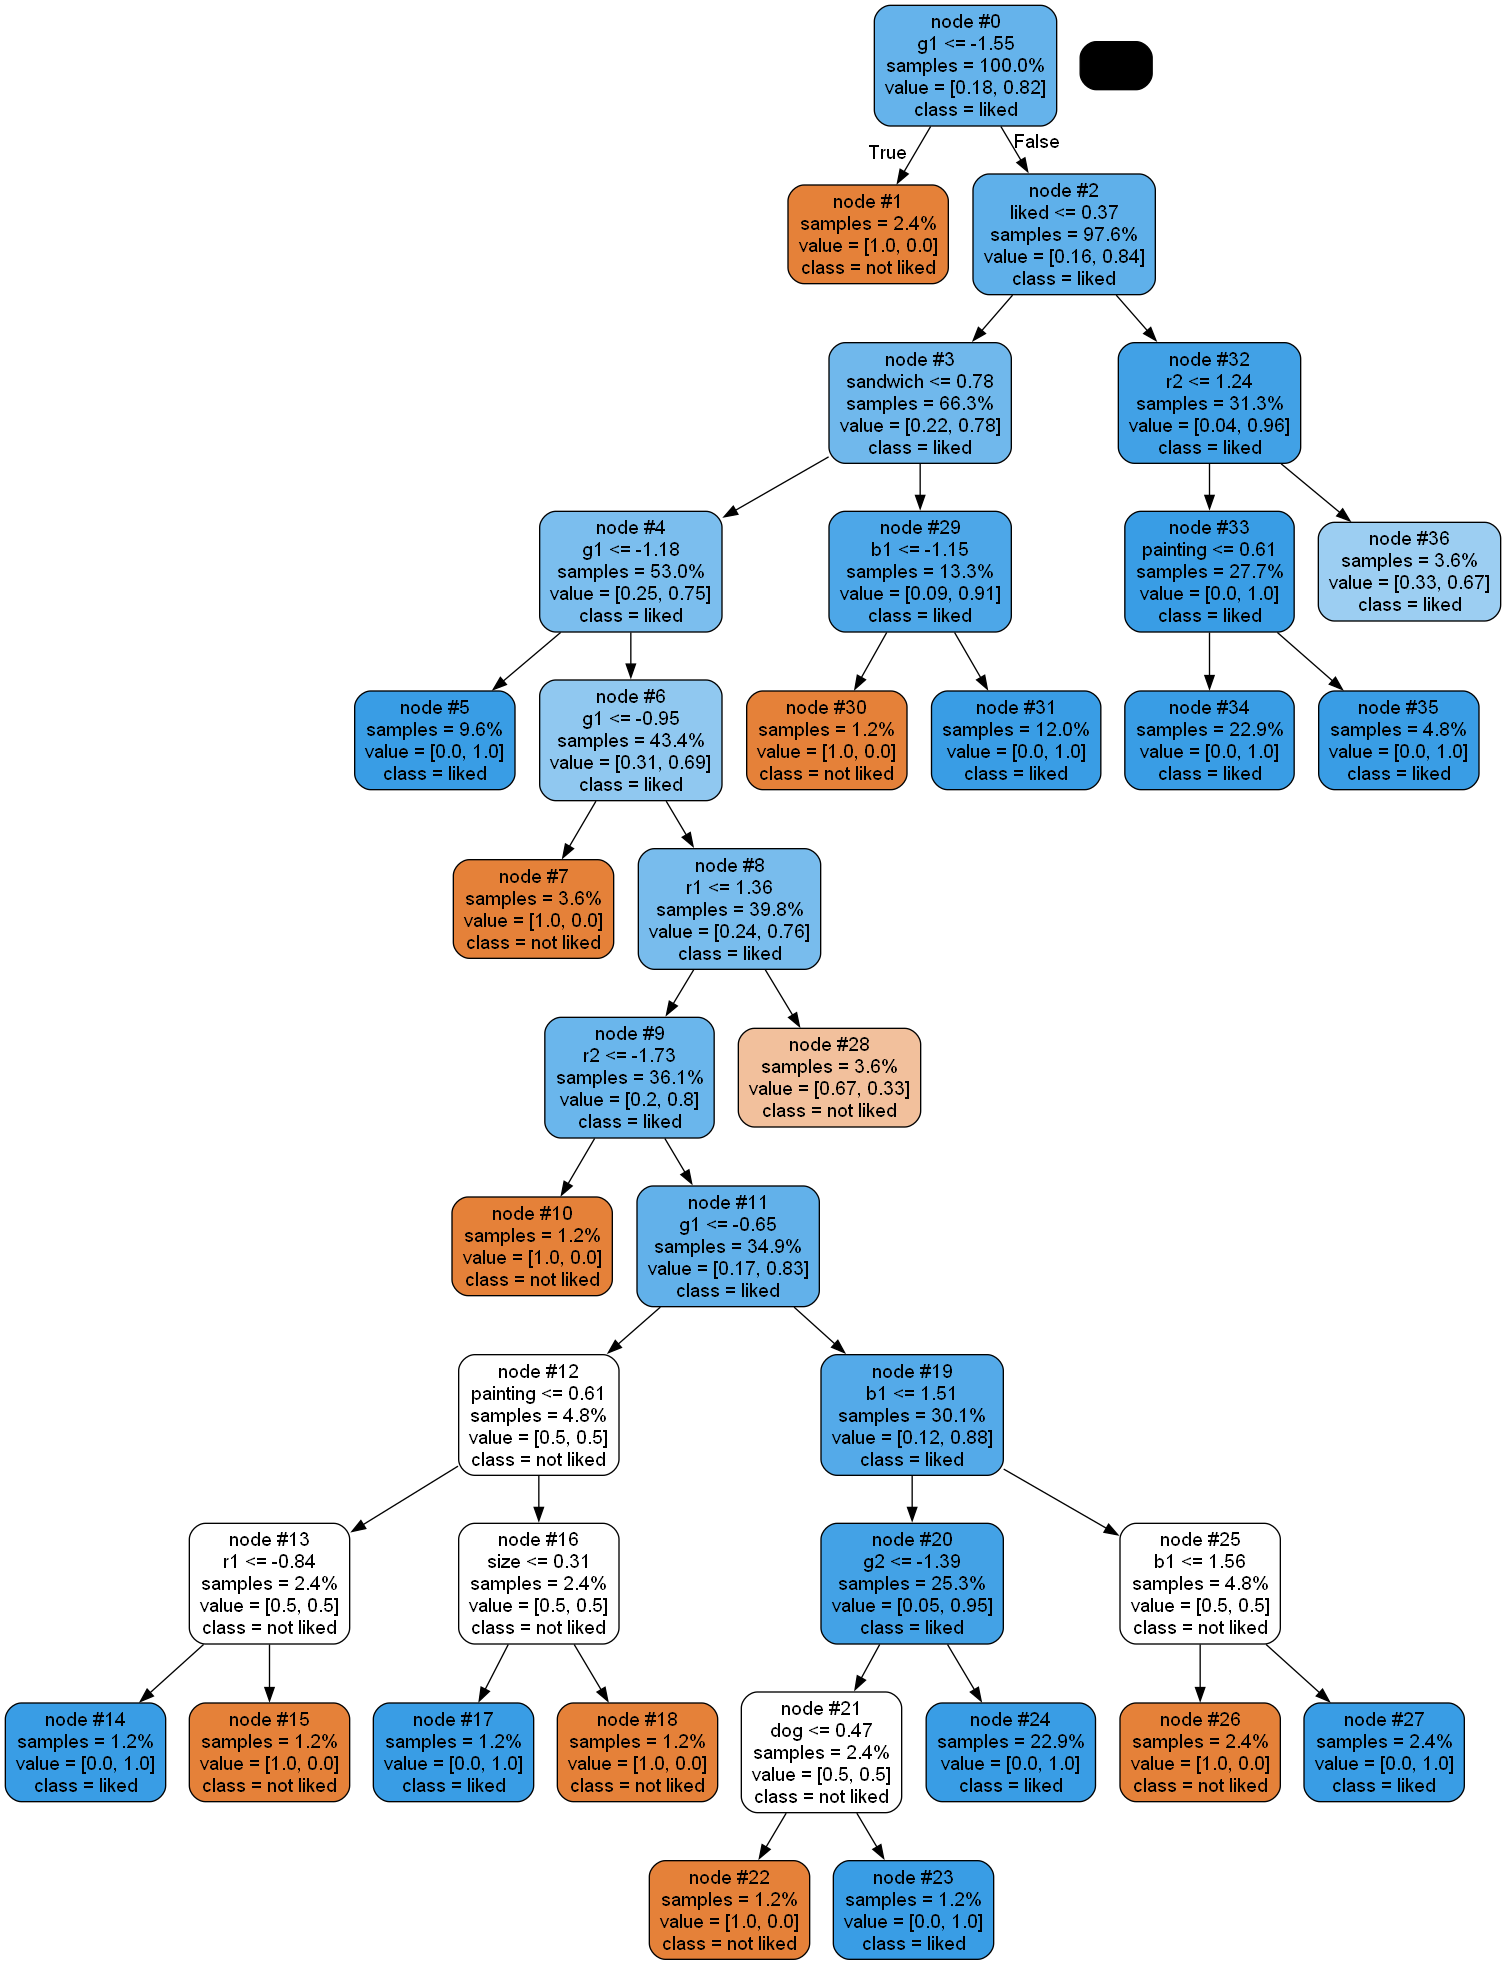

Importance des variables :
1. g1 (0.320553)
2. b1 (0.221239)
3. r1 (0.152816)
4. painting (0.074733)
5. liked (0.053297)
6. r2 (0.050832)
7. size (0.040686)
8. dog (0.040686)
9. g2 (0.033457)
10. sandwich (0.011700)
11. hex1 (0.000000)
12. hex2 (0.000000)
13. flag (0.000000)
14. island (0.000000)
15. format (0.000000)
16. orientation (0.000000)
17. b2 (0.000000)
[0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1]


In [9]:
# Importation des bibliothèques nécessaires
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import graphviz
import pydotplus
import pandas as pd

# Identifier les colonnes qui contiennent des valeurs de type chaîne de caractères
string_cols = dataFrame.select_dtypes(include=['object']).columns

# Convertir les colonnes en un type numérique approprié
for col in string_cols:
    dataFrame[col] = pd.to_numeric(dataFrame[col], errors='coerce')

# Supprimer les lignes contenant des valeurs manquantes
#dataFrame.dropna(inplace=True)
 
# Afficher la forme du dataframe après prétraitement
print(dataFrame.shape)
print(resultframe.shape)

# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(dataFrame, resultframe, test_size=0.2, random_state=69)

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entraînement du modèle
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Évaluation du modèle
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Affichage de l'arbre de décision
dot_data = tree.export_graphviz(
    dtc,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=le7.inverse_transform(resultframe.liked.unique()),
    feature_names=dataFrame.columns,
    proportion=True,
    impurity=False,
    precision=2,
    node_ids=True
)

graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

import io

img = Image.open(io.BytesIO(pydot_graph.create_png()))
display(img)

# Affichage de l'importance des variables
importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))

# Affichage des prédictions
print(y_pred)


In [74]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement du modèle
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=69)
rfc.fit(X_train, y_train.ravel())
# Évaluation du modèle
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Affichage de l'importance des variables
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(len(X_train[0])):
    print("%d. %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))
    
print(y_pred)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.88      1.00      0.94        23

    accuracy                           0.88        26
   macro avg       0.94      0.50      0.47        26
weighted avg       0.90      0.88      0.83        26

Importance des variables :
1. orientation (0.407515)
2. size (0.371578)
3. format (0.089897)
4. r1 (0.079425)
5. g1 (0.051585)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


#Data Visualization 

{2010: 7, 1999: 4, 2005: 3, 2008: 6, 2021: 10, 2002: 4, 2006: 3, 2012: 2, 2001: 4, 2019: 3, 2018: 7, 2015: 6, 2013: 5, 2017: 2, 2011: 4, 2009: 4, 2020: 5, 2014: 2, 2016: 2, 2022: 3, 2004: 1, 2000: 7, 2023: 2, 2024: 3, 2007: 2, 2003: 3}


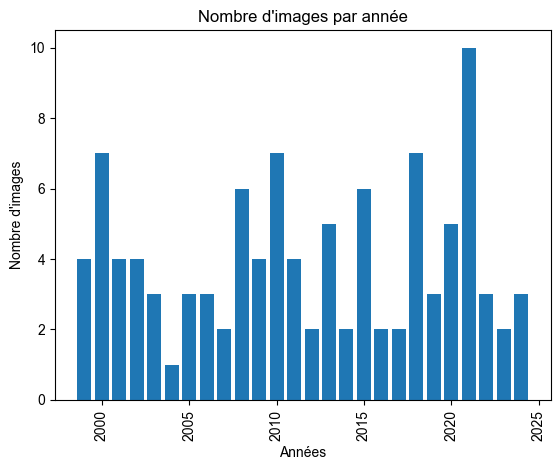

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
nb_images_year = {}

with open('img_data.json', 'r') as f:
    data = json.load(f)
    for image in data:
        date = data[image]["date"] #Recupere la date de l'image
        nb_images_year[date] = nb_images_year.get(date,0) +1
    
print(nb_images_year)
noms = list(nb_images_year.keys())
valeurs = list(nb_images_year.values())

plt.bar(noms, valeurs)
plt.title("Nombre d'images par année")
plt.xlabel("Années")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90)
plt.show()

{'large': 53, 'medium': 30, 'small': 21}
{'landscape': 77, 'portrait': 25, 'squared': 2}
{'DSC-H50': 1, 'Panasonic': 9, 'Fujifilm': 7, 'DSC-P150': 1, 'Nikon': 9, 'DMC-TZ27': 1, 'iphone': 6, 'COOLPIX S5100\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': 1, 'lenovo': 4, 'Canon EOS REBEL T1i': 1, 'Sony': 9, 'Canon': 11, 'DMC-FZ20': 1, 'Pentax': 3, 'samsung': 6, 'Olympus': 5, 'NIKON D610': 1, 'PENTAX Optio330RS': 1, 'E5200': 1, 'XZ-1            ': 1, 'Canon DIGITAL IXUS v3': 1, 'Canon EOS 5D Mark II': 1, 'NIKON D7000': 1, 'NIKON D5000': 1, 'DSC-V1': 1, 'Canon EOS 450D': 1, 'Canon EOS 400D DIGITAL': 1, 'Canon DIGITAL IXUS 430': 1, 'Canon EOS 650D': 1, 'iPhone 4S': 1, 'iPhone XS': 1, 'NIKON D90': 1, 'C765UZ': 1, 'Canon PowerShot SD20': 1, 'iPhone 8 Plus': 1, 'DSC-T100': 1, 'E5700': 1, 'Canon DIGITAL IXUS 100 IS': 1, 'GT-I9100': 1, 'Hasselblad CF528-39 - Hasselblad H Series': 1, 'FinePix S100FS ': 1, 'Hasselblad H4D-50': 1, 'MP260 series': 1, 'P65+': 1, 'HP Scanjet G

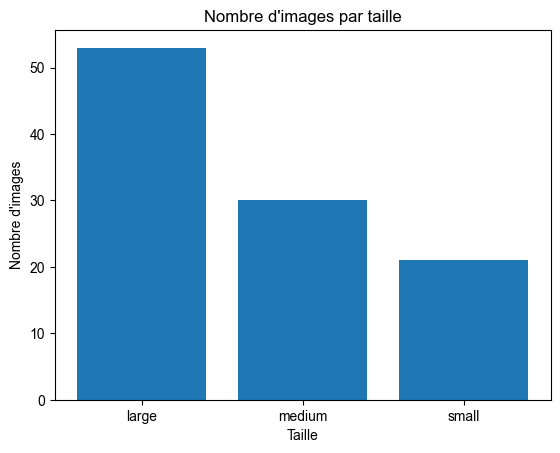

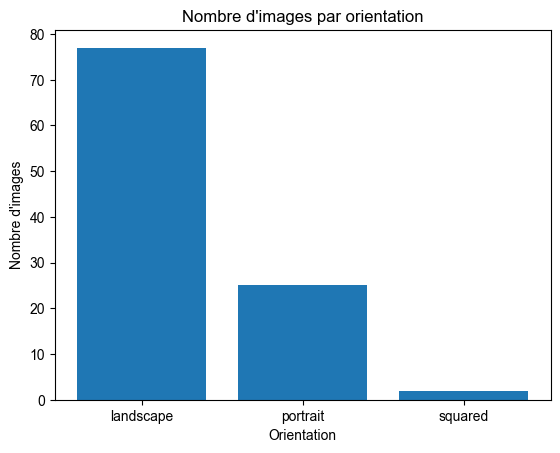

C:\Users\chaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


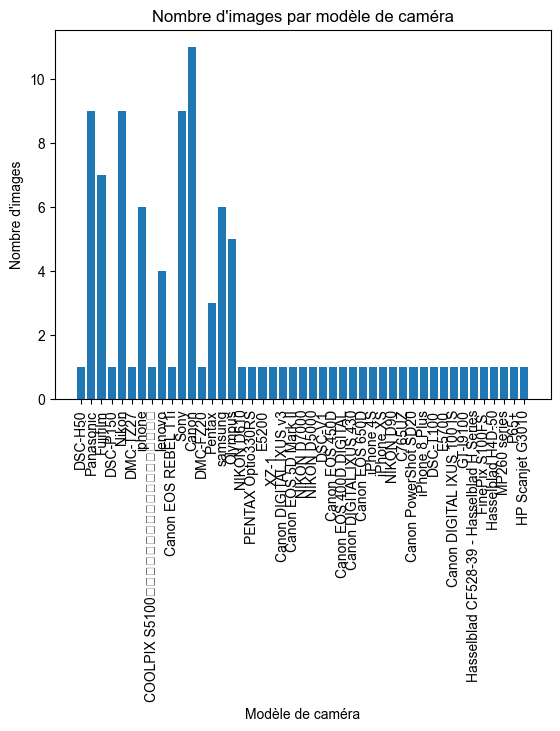

In [25]:
nb_images_size = {}
nb_images_orientation = {}
nb_images_camera = {}

plt.rcParams['font.family'] = 'Arial'
with open('img_data.json', 'r') as f:
    data = json.load(f)
    for image in data :
       size = data[image].get('size','')
       nb_images_size[size] = nb_images_size.get(size,0) +1
      
       orientation = data[image].get('orientation','')
       nb_images_orientation[orientation] = nb_images_orientation.get(orientation,0) +1
      
       camera = data[image].get('model','')
       nb_images_camera[camera] = nb_images_camera.get(camera,0) +1
  
print(nb_images_size)
print(nb_images_orientation)
print(nb_images_camera)
entity1 = list(nb_images_size.keys())
val1 = list(nb_images_size.values())
plt.bar(entity1, val1)
plt.title("Nombre d'images par taille")
plt.xlabel("Taille")
plt.ylabel("Nombre d'images")
plt.show()


entity2 = list(nb_images_orientation.keys())
val2 = list(nb_images_orientation.values())
plt.bar(entity2, val2)
plt.title("Nombre d'images par orientation")
plt.xlabel("Orientation")
plt.ylabel("Nombre d'images")
plt.show()


entity3 = list(nb_images_camera.keys())
val3 = list(nb_images_camera.values())
plt.bar(entity3, val3)
plt.title("Nombre d'images par modèle de caméra")
plt.xlabel("Modèle de caméra")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90) # Fait pivoter les étiquettes x de 45 degrés pour améliorer la lisibilité
plt.show()

{'DSC-H50': ['DSC-H50'], 'Panasonic': ['Panasonic'], 'Fujifilm': ['Fujifilm'], 'DSC-P150': ['DSC-P150'], 'Nikon': ['Nikon'], 'DMC-TZ27': ['DMC-TZ27'], 'iphone': ['iphone'], 'COOLPIX': ['COOLPIX S5100\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'], 'lenovo': ['lenovo'], 'Canon': ['Canon EOS REBEL T1i', 'Canon', 'Canon DIGITAL IXUS v3', 'Canon EOS 5D Mark II', 'Canon EOS 450D', 'Canon EOS 400D DIGITAL', 'Canon DIGITAL IXUS 430', 'Canon EOS 650D', 'Canon PowerShot SD20', 'Canon DIGITAL IXUS 100 IS'], 'Sony': ['Sony'], 'DMC-FZ20': ['DMC-FZ20'], 'Pentax': ['Pentax'], 'samsung': ['samsung'], 'Olympus': ['Olympus'], 'NIKON': ['NIKON D610', 'NIKON D7000', 'NIKON D5000', 'NIKON D90'], 'PENTAX': ['PENTAX Optio330RS'], 'E5200': ['E5200'], 'XZ-1': ['XZ-1            '], 'DSC-V1': ['DSC-V1'], 'iPhone': ['iPhone 4S', 'iPhone XS', 'iPhone 8 Plus'], 'C765UZ': ['C765UZ'], 'DSC-T100': ['DSC-T100'], 'E5700': ['E5700'], 'GT-I9100': ['GT-I9100'], 'Hasselblad': ['Hasselblad CF528-3

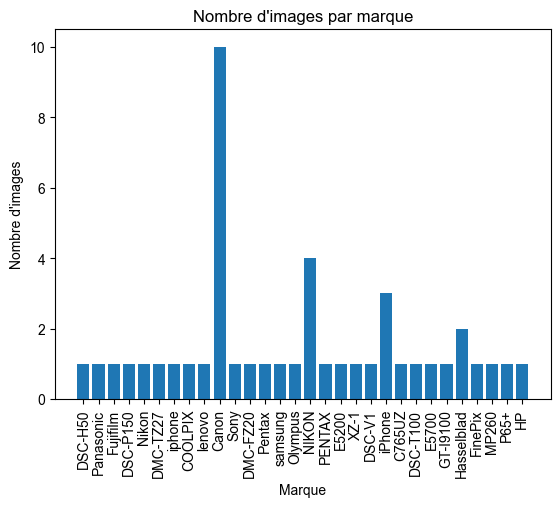

In [26]:
marques = {}

for modele in nb_images_camera:
    marque = modele.split(' ')[0].encode('utf-8', 'ignore').decode('utf-8') # Encode la chaîne de caractères en utilisant l'encodage UTF-8 et en ignorant les caractères invalides
    if marque in marques:
        marques[marque].append(modele)
    else:
        marques[marque] = [modele]

print(marques)

entity4 = list(marques.keys())
print([len(el) for el in marques.values()])
val4 = [len(el) for el in marques.values()]
plt.bar(entity4, val4)
plt.title("Nombre d'images par marque")
plt.xlabel("Marque")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90) # Fait pivoter les étiquettes x de 45 degrés pour améliorer la lisibilité
plt.show()


# Color Characteristics
## En 2D 

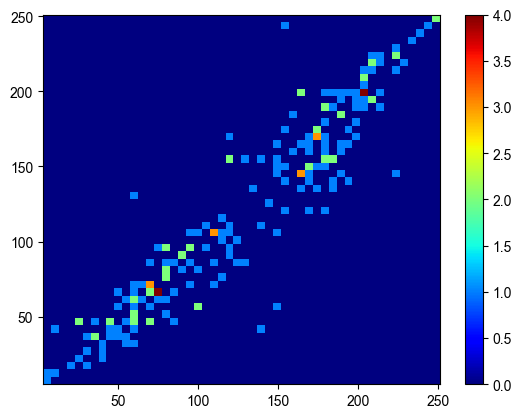

In [29]:
# Initialiser un tableau vide pour stocker toutes les couleurs
all_colors = []

# Parcourir toutes les images et ajouter leurs couleurs à la liste de toutes les couleurs

for image in data:
    if 'colors' in data[image]:
        colors = data[image]['colors']
        all_colors += colors

# Convertir la liste de couleurs en un tableau NumPy
all_colors = np.array(all_colors)

# Créer l'histogramme en utilisant Matplotlib
plt.hist2d(all_colors[:, 0], all_colors[:, 1], bins=50, cmap=plt.cm.jet)
plt.colorbar()

# Afficher l'histogramme
plt.show()

## En 3D mais avec toutes les couleurs de chaques images

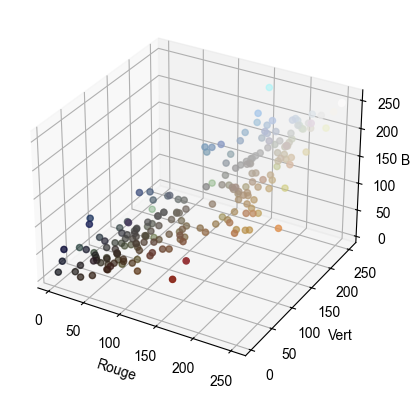

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcl

# Initialiser les listes de coordonnées x, y et z
x = []
y = []
z = []

# Initialiser la liste de couleurs
colors = []

# Parcourir toutes les images dans le fichier JSON
for image in data:
    # Vérifier si l'image actuelle a une clé 'colors'
    if 'colors' in data[image]:
        # Parcourir toutes les couleurs pour cette image
        for color in data[image]['colors']:
            # Ajouter les valeurs RGB aux listes x, y et z
            r, g, b = color
            x.append(r)
            y.append(g)
            z.append(b)
            # Ajouter la couleur à la liste de couleurs
            colors.append(mcl.to_hex([r/255,g/255,b/255]))

# Créer une figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ajouter les points au graphique en 3D
ax.scatter(x, y, z, c=colors, marker='o')

# Ajouter des labels aux axes
ax.set_xlabel('Rouge')
ax.set_ylabel('Vert')
ax.set_zlabel('Bleu')

# Afficher le graphique
plt.show()


# Recommendation System

## 1- Sur une image

In [81]:
# Prédiction sur une image au hasard:
dataFrame = pd.read_json('img_data.json').T

ligne_aleatoire = dataFrame.sample()

ligne_aleatoire

,size,orientation,format,colors,date,model,tags
Q85774221-Q28803,medium,landscape,JPEG,"[[147, 107, 72], [207, 195, 193]]",2003,DSC-T100,[sandwich]


## 2- Sur toutes nos données

In [90]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Sample data
data = []
with open('img_data.json') as f:
    json_data = json.load(f)
    for image in json_data:
        try:
            data.append([
                str(json_data[image]["colors"][0]),
                str(json_data[image]["colors"][1]),
                json_data[image]["size"],
                json_data[image]["orientation"],
                json_data[image]["format"]
            ])
        except:
            pass

# Encode categorical features and labelss
label_encoders = [LabelEncoder() for _ in range(len(data[0]))]
encoded_data = []
for i, column in enumerate(zip(*data)):
    encoded_data.append(label_encoders[i].fit_transform(column))

X = list(zip(*encoded_data))  # Features
y = np.ravel(resultframe)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the logistic regression classifier
classifier = svm.SVC(class_weight={1: 1, 0: 6})
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Sample prediction
for image in json_data:
    sample_item = [
        str(json_data[image]["colors"][0]),
        str(json_data[image]["colors"][1]),
        json_data[image]["size"],
        json_data[image]["orientation"],
        json_data[image]["format"]
    ]
    encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
    prediction = classifier.predict([encoded_item])[0]
    print(f"Predictions pour l'ensemble de nos images : {image} : {prediction}")

Accuracy: 0.6153846153846154
Predictions pour l'ensemble de nos images : Q7660509-Q144 : 1
Predictions pour l'ensemble de nos images : Q7704028-Q144 : 1
Predictions pour l'ensemble de nos images : Q7802871-Q144 : 1
Predictions pour l'ensemble de nos images : Q7809730-Q144 : 1
Predictions pour l'ensemble de nos images : Q9049682-Q144 : 1
Predictions pour l'ensemble de nos images : Q12065066-Q144 : 1
Predictions pour l'ensemble de nos images : Q13647435-Q144 : 0
Predictions pour l'ensemble de nos images : Q16069677-Q144 : 1
Predictions pour l'ensemble de nos images : Q16846342-Q144 : 0
Predictions pour l'ensemble de nos images : Q16938954-Q144 : 0
Predictions pour l'ensemble de nos images : Q18392844-Q144 : 1
Predictions pour l'ensemble de nos images : Q18408091-Q144 : 0
Predictions pour l'ensemble de nos images : Q19362107-Q144 : 0
Predictions pour l'ensemble de nos images : Q19362108-Q144 : 0
Predictions pour l'ensemble de nos images : Q42235-Q144 : 1
Predictions pour l'ensemble de nos

# Tests avec Unittest

In [99]:
import unittest
import json
from datetime import datetime

class TestImageAttributes(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        with open('img_data.json') as file:
            cls.img_data = json.load(file)

    def test_images_downloaded(self):
        expected_categories = {'dog', 'flag', 'island', 'sandwich', 'painting'}
        for image_id, attributes in self.img_data.items():
            tags = set(attributes.get('tags', []))
            # Vérifie si au moins une des catégories attendues se trouve dans les tags de l'image
            self.assertTrue(any(tag in tags for tag in expected_categories), f"Échec pour {image_id}: aucune catégorie correspondante trouvée parmi {tags}")


    def test_colors(self):
        for image_id, attributes in self.img_data.items():
            colors = attributes.get('colors', [])
            for color in colors:
                self.assertEqual(len(color), 3, f"Échec pour {image_id}: couleur non conforme {color}")
                for value in color:
                    self.assertTrue(0 <= value <= 255, f"Échec pour {image_id}: valeur de couleur invalide {value}")

    def test_orientation_size_model(self):
        for image_id, attributes in self.img_data.items():
            orientation = attributes.get('orientation')
            size = attributes.get('size')
            model = attributes.get('model')
            self.assertIn(orientation, ['portrait', 'landscape', 'squared'], f"Échec pour {image_id}: orientation invalide {orientation}")
            self.assertIn(size, ['small', 'medium', 'large'], f"Échec pour {image_id}: taille invalide {size}")
            self.assertIsInstance(model, str, f"Échec pour {image_id}: modèle invalide {model}")

    def test_valid_sizes(self):
        valid_sizes = {'small', 'medium', 'large'}
        for image_id, attributes in self.img_data.items():
            size = attributes.get('size')
            self.assertIn(size, valid_sizes, f"Échec pour {image_id}: taille invalide {size}")

    def test_valid_orientations(self):
        valid_orientations = {'portrait', 'landscape', 'squared'}
        for image_id, attributes in self.img_data.items():
            orientation = attributes.get('orientation')
            self.assertIn(orientation, valid_orientations, f"Échec pour {image_id}: orientation invalide {orientation}")

    def test_valid_formats(self):
        valid_formats = {'JPEG', 'PNG', 'TIFF', 'MPO'}
        for image_id, attributes in self.img_data.items():
            format = attributes.get('format')
            self.assertIn(format, valid_formats, f"Échec pour {image_id}: format invalide {format}")

    def test_valid_dates(self):
        for image_id, attributes in self.img_data.items():
            date = attributes.get('date')
            self.assertIsInstance(date, int, f"Échec pour {image_id}: date invalide {date}")
            self.assertTrue(1990 <= date <= 2024, f"Échec pour {image_id}: date hors plage {date}")

    def test_valid_models(self):
        for image_id, attributes in self.img_data.items():
            model = attributes.get('model')
            self.assertIsInstance(model, str, f"Échec pour {image_id}: modèle invalide {model}")

    def test_valid_and_temporally_consistent_dates(self):
        earliest_acceptable_year = 1990  # Ajustez selon le contexte technologique pertinent
        current_year = datetime.now().year
        for image_id, attributes in self.img_data.items():
            date = attributes.get('date')
            self.assertIsInstance(date, int, f"Échec pour {image_id}: date invalide {date}")
            self.assertTrue(earliest_acceptable_year <= date <= current_year, 
                            f"Échec pour {image_id}: date hors plage {date} (attendu entre {earliest_acceptable_year} et {current_year})")


# Chargement des tests
test_loader = unittest.TestLoader()
test_suite = test_loader.loadTestsFromTestCase(TestImageAttributes)

# Exécution des tests
test_runner = unittest.TextTestRunner(verbosity=2)
test_runner.run(test_suite)

test_colors (__main__.TestImageAttributes) ... ok
test_images_downloaded (__main__.TestImageAttributes) ... ok
test_orientation_size_model (__main__.TestImageAttributes) ... ok
test_valid_and_temporally_consistent_dates (__main__.TestImageAttributes) ... ok
test_valid_dates (__main__.TestImageAttributes) ... ok
test_valid_formats (__main__.TestImageAttributes) ... ok
test_valid_models (__main__.TestImageAttributes) ... ok
test_valid_orientations (__main__.TestImageAttributes) ... ok
test_valid_sizes (__main__.TestImageAttributes) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.024s

OK


<unittest.runner.TextTestResult run=9 errors=0 failures=0>